# Анализ времени заправок для Яндекс.Навигатора

Яндекс собирается запускать(возможно, уже запустил) сервис оплаты заправки на АЗС из Яндекс.Навигатора — водители оплачивают бензин через приложение, не выходя из машины. Необходимо провести анализ рынка для сервиса онлайн-оплаты заправки и оценить среднее время, которое водители проводят на АЗС. Подготовить список потенциальных партнёров — крупных сетей АЗС.

Коллеги из Навигатора собрали необходимые данные и прислали их в таком виде:
-  Зашифрованное наименование сети АЗС (столбец name): вместо брендов — названия растений;
-  Уникальный идентификатор конкретной АЗС (столбец id) — в сети их много;
-  Время заезда на АЗС (столбец date_time) в формате ISO: 20190405T165358 означает, что водитель прибыл на заправку 5 апреля 2019 года в 16 часов 53 минуты 58 секунд по UTC.
-  Проведённое на АЗС время (столбец time_spent) в секундах.

Нужно ответить на вопрос, сколько в среднем времени тратят водители на заправку в каждой из сетей АЗС.

In [1]:
import pandas as pd

data = pd.read_csv('yandex_azs.txt', sep = '\t', encoding = 'windows-1251')
data = data.drop(['col'], axis=1)
data.head()

,date_time,id,time_spent,name
0,20180406T165358,76144fb2,98.0,Василек
1,20180404T173913,76144fb2,15.0,Василек
2,20180403T172824,76144fb2,220.0,Василек
3,20180407T070441,76144fb2,19.0,Василек
4,20180404T132049,76144fb2,14.0,Василек


In [2]:
name_stat= data.pivot_table(index ='name', values ='time_spent') 
print(name_stat)

             time_spent
name                   
Агератум     337.802721
Амарант      132.760012
Аммобиум     256.708042
Арктотис      73.879984
Астильба     376.143149
Бальзамин    134.508411
Бархатцы     145.300328
Бегония      163.200647
Белоцветник  100.818966
Василек      268.849897
Вербена      190.016594
Вероника     220.019402
Гацания      160.685185
Гвоздика     294.317308
Гейхера      167.445947
Гелихризум   290.138643
Георгина     166.785610
Годеция      113.958333
Диморфотека  406.161017
Доротеантус  263.568916
Ирис         179.931159
Календула    207.357323
Колокольчик  119.131564
Космос       164.867797
Крокус       349.031746
Лаватера     249.992844
Левкой       187.465606
Лобулярия     96.834350
Люпин        235.440937
Малопа        76.070543
Мальва       136.562234
Нарцисс       68.166758
Настурция    154.859694
Незабудка    120.362398
Немезия      186.535207
Обриета      141.777778
Петуния      265.780822
Пион         222.565523
Подснежник   180.286207
Роза         260

In [3]:
total_visits = data.shape[0]#количество заездов на АЗС 
print('Количество заездов: {}'.format(total_visits))
total_stations = len(data['id'].unique())
print ('Количество АЗС:', total_stations)
print(data['date_time'].min(), data['date_time'].max())
total_days = 7
station_visits_per_day = total_visits/ total_stations / total_days
print('Количество заездов на АЗС в сутки:', station_visits_per_day)

data_visits = data['name'].value_counts().sort_values(ascending=False)
print(data_visits.head(10))

Количество заездов: 317064
Количество АЗС: 471
20180402T000008 20180408T235957
Количество заездов на АЗС в сутки: 96.16742493175614
Календула      85648
Василек        79006
Георгина       34316
Немезия        20138
Колокольчик    18835
Мальва         17386
Гейхера        14125
Доротеантус     6312
Нарцисс         3640
Амарант         3221
Name: name, dtype: int64


Календула и Василек лидеры рынка, а значит с распределением все в порядке.
С объемом данных тоже все хорошо.
Смотрим дальше.

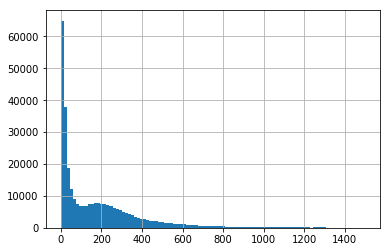

In [5]:
data['time_spent'].hist(bins=100, range=(0, 1500))

Как-то очень много значений около 0. Выбросы? Смотрим дальше.

(-100, 1000)

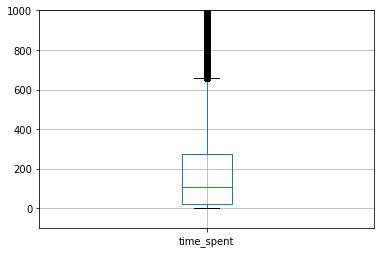

In [6]:
import matplotlib.pyplot as plt
data.boxplot()
plt.ylim(-100, 1000)

Теперь видно, что большинство значений лежит от 0-300, правдоподобно. Однако, при этом 1 квартиль лежитт менее чем 50 секунд. Странно...

In [7]:
data.describe()

,time_spent
count,317064.000000
mean,203.405338
std,395.774174
min,0.000000
25%,19.000000
50%,108.000000
75%,274.000000
max,28925.000000


среднее слишком отличается от медианы...

Слишком долгая заправка...
Во-первых, их немного. Во-вторых, скорее всего, такие заезды — не заправки. Например, водитель мог отдыхать, есть или заниматься чем-то ещё. Раз это не заправки в чистом виде, значит в рамках нашего исследования такие заезды не интересны.
Как определить, что заправка «слишком долгая»? Где провести границу между заправкой автомобиля и прочими занятиями на АЗС?

Из гистаграммы..
Заправки продолжительностью 600 секунд — уже редки. Дольше 800 секунд почти не заправляются. А на участке более 1300 секунд гистограмма сливается с нулём (это не значит, что там ровно 0, но таких заправок единицы).
Примем верхнюю границу в 1000 секунд. Это число кажется разумным: дольше заправляются редко. Отбросив значения больше 1000, мы не потеряем много данных. Да и вряд ли водители тратят на заправку больше 1000 секунд (16 минут).

In [8]:
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%dT%H:%M:%S')
data['local_time'] = data['date_time'] + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')

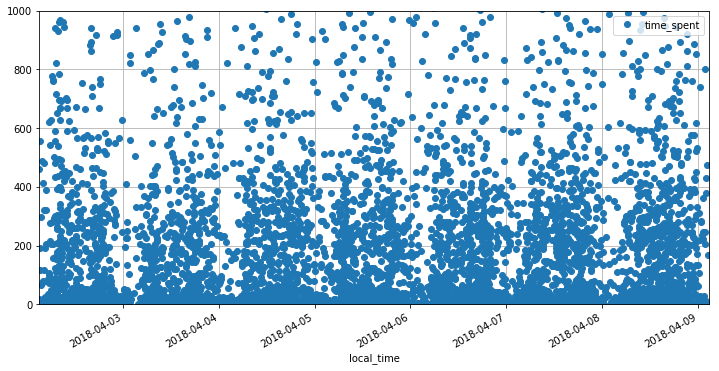

In [9]:
sample = data.query("id == '3c1e4c52'")
sample.plot(x='local_time', y='time_spent', style='o', grid=True, ylim=(0, 1000), figsize=(12, 6))

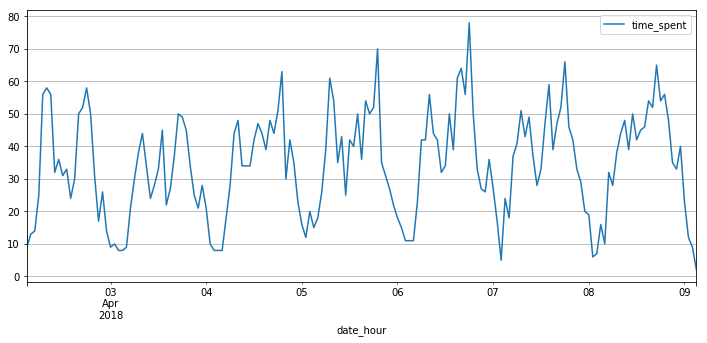

In [10]:
(data
         .query('id == "3c1e4c52"')
         .pivot_table(index='date_hour', values='time_spent', aggfunc='count')
         .plot(grid=True, figsize=(12, 5))
);

Да, ночью заездов значительно меньше, чем днем. Это похоже на правду. Т.е данные в общем правдоподрбны, но что делать с временем заезда ближе к 0. Смотрим далее...

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A4E3A90>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A4E37F0>]]


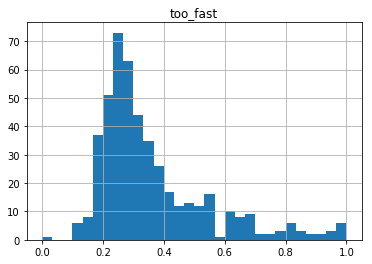

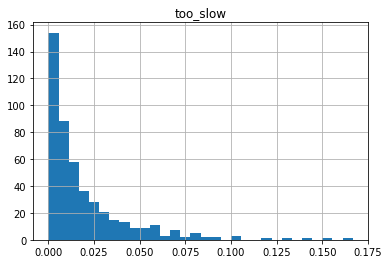

In [11]:
data['too_fast'] = data['time_spent'] < 60
too_fast_stat = data.pivot_table(index="id", values="too_fast")
print(too_fast_stat.hist(bins=30))

data['too_slow'] = data['time_spent'] > 1000
too_slow_stat = data.pivot_table(index="id", values="too_slow")
print(too_slow_stat.hist(bins=30))

Аномально длинных заправок значительно меньше, чем очень коротких. На большинстве заправок длительность заездом меньше 5%. Не будем рассматривать очень длительные запраки.

Мы решили отбросить слишком долгие заезды (более 1000 секунд), а для надёжности вместо среднего арифметического времени рассчитывать медианное. Тогда эти заезды не исказят оценку типичной продолжительности заправки.
А вот с короткими заездами всё не так радужно. Их гораздо больше. Есть АЗС, где коротких заправок большинство, а то и все 100%. Что-то здесь не то.
Ошибка в исходных данных? Сформулируем проблему, чтобы упростить поиск потенциальной ошибки в алгоритме выгрузки данных. 

In [12]:
too_fast_stat = data.pivot_table(index="id", values="too_fast")
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index and 60 <= time_spent <= 1000')
good_stations_stat = good_data.pivot_table(index='id', values='time_spent', aggfunc='median')
good_stat = good_data.pivot_table(index='name', values='time_spent', aggfunc='median')

print(good_stat.sort_values(by='time_spent'))

             time_spent
name                   
Белоцветник       154.0
Бальзамин         158.0
Незабудка         161.0
Колокольчик       161.0
Обриета           167.0
Функия            171.5
Гацания           178.5
Аммобиум          180.5
Пион              180.5
Бархатцы          181.5
Мальва            182.0
Ирис              185.0
Арктотис          185.0
Люпин             186.0
Амарант           187.5
Хризантема        188.0
Тюльпан           190.0
Ромашка           191.0
Бегония           195.0
Вербена           199.0
Гейхера           204.0
Вероника          212.0
Левкой            212.5
Подснежник        218.5
Доротеантус       220.0
Диморфотека       224.0
Немезия           226.0
Гвоздика          229.0
Малопа            229.0
Календула         254.0
Крокус            257.5
Василек           264.0
Космос            267.0
Георгина          279.0
Лаватера          282.0
Агератум          309.0
Роза              315.0
Петуния           319.5
Гелихризум        342.0
Астильба        

Получили рейтинг заправок...

In [13]:
stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(index='name', values='time_spent', aggfunc='median')

stat['good_time_spent'] = good_stat['time_spent']
print(stat)

             time_spent  good_time_spent
name                                    
Агератум     337.802721            309.0
Амарант      132.760012            187.5
Аммобиум     256.708042            180.5
Арктотис      73.879984            185.0
Астильба     376.143149            423.0
Бальзамин    134.508411            158.0
Бархатцы     145.300328            181.5
Бегония      163.200647            195.0
Белоцветник  100.818966            154.0
Василек      268.849897            264.0
Вербена      190.016594            199.0
Вероника     220.019402            212.0
Гацания      160.685185            178.5
Гвоздика     294.317308            229.0
Гейхера      167.445947            204.0
Гелихризум   290.138643            342.0
Георгина     166.785610            279.0
Годеция      113.958333              NaN
Диморфотека  406.161017            224.0
Доротеантус  263.568916            220.0
Ирис         179.931159            185.0
Календула    207.357323            254.0
Колокольчик  119

После фильтрации типичная продолжительность заправки изменилась. Причем неодинаково в разных сетях.
В некоторых сетях изменения незначительны, например, у Агератум  с   337.802721     до       309.0.
Есть и значительные изменения, например, у Арктотис    с  73.879984   до         185.0.
Отдельно стиоит отметить сеть, у которых медианное время стало Nan.


In [14]:
id_name = good_data.pivot_table(index = 'id', values = 'name', aggfunc = ['first','count'])
id_name.columns = ['name','count']
print(id_name.head())

                 name  count
id                          
00ca1b70     Вероника    131
0178ce70      Василек    164
01abf4e9      Гацания     30
030a9067  Колокольчик    228
03740f2d      Василек    157


In [15]:
station_stat_full = id_name.join(good_stations_stat)

good_stat2 = (
    station_stat_full
    .query('count > 30')
    .pivot_table(index='name', values='time_spent', aggfunc=['median', 'count'])
)
good_stat2.columns = ['median_time', 'stations']

final_stat = stat .join(good_stat2)
print(final_stat)

             time_spent  good_time_spent  median_time  stations
name                                                           
Агератум     337.802721            309.0       308.50       3.0
Амарант      132.760012            187.5       169.00       5.0
Аммобиум     256.708042            180.5       178.75       4.0
Арктотис      73.879984            185.0       190.50       3.0
Астильба     376.143149            423.0       435.50       4.0
Бальзамин    134.508411            158.0       158.00       1.0
Бархатцы     145.300328            181.5       181.50       1.0
Бегония      163.200647            195.0       190.00       3.0
Белоцветник  100.818966            154.0       154.00       1.0
Василек      268.849897            264.0       252.00     103.0
Вербена      190.016594            199.0       199.75       6.0
Вероника     220.019402            212.0       223.00       5.0
Гацания      160.685185            178.5       178.50       1.0
Гвоздика     294.317308            229.0

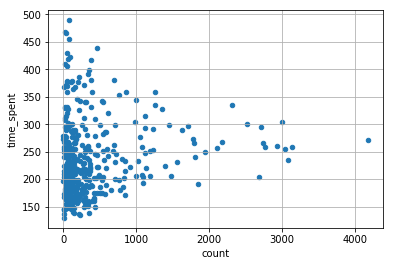

In [16]:
station_stat_full.plot(x='count', y='time_spent', kind='scatter', grid=True)


Такой график уже лучше отражает 
АЗС с малым числом заездов имеют значительный разброс среднего времени заправки (от 120 до 500). Остальные обычно укладываются в границы 200-350 секунд. Это наводит на две идеи:
АЗС с большим числом заездов — крупные, процессы на них отлажены, вот и время одинаковое.
Где мало заездов, там искажения данных более вероятны.

In [17]:
print(station_stat_full ['count'].corr(station_stat_full ['time_spent']))

0.12242632473597162


Скорее всего связи между числом заездов и продолжительностью заправки нет.

            time_spent  too_fast  too_slow
time_spent    1.000000 -0.640658  0.802246
too_fast     -0.640658  1.000000 -0.255875
too_slow      0.802246 -0.255875  1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009FA1780>,
      dtype=object)

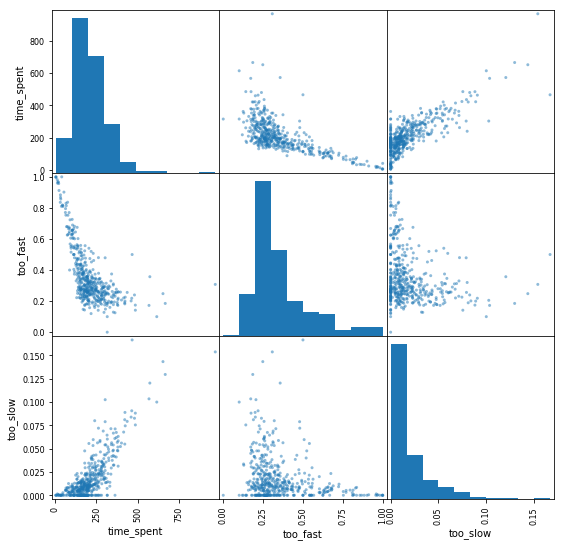

In [18]:
station_stat_multi = data.pivot_table(index='id', values=['time_spent', 'too_fast', 'too_slow'], aggfunc='mean')

print(station_stat_multi.corr())

pd.plotting.scatter_matrix(station_stat_multi, figsize=(9, 9))

еще раз убедились, что отбросили ненужные данные

Самый большой коэффициент корреляции: 0,8 между 'too_slow' и 'time_spent'. Это заметно и на соответствующей диаграмме рассеяния. Зная одно значение, можно предсказать другое. Если бы мы не отрезали слишком долгие заезды, они бы сказались на среднем времени. Поэтому так важно было их отбросить и вместо среднего значения взять медиану.
Зависимость между 'too_fast' и 'time_spent' интереснее. На диаграмме рассеяния видно, что при too_fast>0.6 (т.е. более 60% заездов на АЗС продолжались меньше минуты), среднее время почти полностью определяется как раз долей этих быстрых заездов.

Графики подтверждают, что двигаетесь вы верным путём и скоро возьмётесь за статистику, которая может открыть что-то новое. 

Продемонстрируйте два изображения: матрицу диаграмм рассеяния по исходным данным — и по отфильтрованным.

                 time_spent  too_fast  too_slow  good_time_spent
time_spent         1.000000 -0.640658  0.802246         0.702429
too_fast          -0.640658  1.000000 -0.255875        -0.315120
too_slow           0.802246 -0.255875  1.000000         0.445926
good_time_spent    0.702429 -0.315120  0.445926         1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009FE33C8>,
      dtype=object)

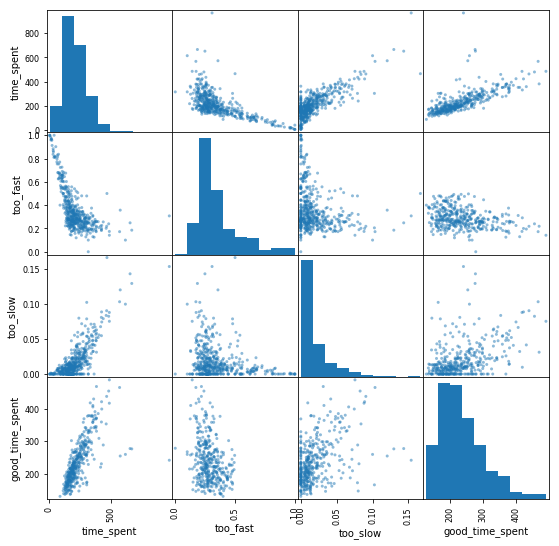

In [19]:
too_fast_stat = data.pivot_table(index='id', values='too_fast')
good_ids = too_fast_stat.query('too_fast < 0.5')
good_data = data.query('id in @good_ids.index')
good_data = good_data.query('60 <= time_spent <= 1000')

station_stat = data.pivot_table(index="id", values="time_spent", aggfunc="median")
good_station_stat = good_data.pivot_table(index="id", values="time_spent", aggfunc="median")

stat = data.pivot_table(index='name', values='time_spent')
good_stat = good_data.pivot_table(index='name', values='time_spent', aggfunc='median')
stat['good_time_spent'] = good_stat['time_spent']

name_stat = data.pivot_table(index='name', values='time_spent')
good_name_stat = good_data.pivot_table(index='name', values='time_spent', aggfunc='median')
name_stat['good_time_spent'] = good_name_stat['time_spent']

id_name = good_data.pivot_table(index='id', values='name', aggfunc=['first', 'count'])
id_name.columns = ['name', 'count']
station_stat_full = id_name.join(good_station_stat)

good_stat2 = (
    station_stat_full
    .query('count > 30')
    .pivot_table(index='name', values='time_spent', aggfunc=['median', 'count'])
)
good_stat2.columns = ['median_time', 'stations']
final_stat = stat.join(good_stat2)

station_stat_multi = data.pivot_table(index='id', values=['time_spent', 'too_fast', 'too_slow'])
station_stat_multi['good_time_spent'] = good_station_stat['time_spent']
print(station_stat_multi.corr())
pd.plotting.scatter_matrix(station_stat_multi, figsize=(9, 9))

Хорошие новости: мы снизили влияние подозрительных данных на итоговый результат. Так, коэффициент корреляции между значениями 'too_fast' и 'good_time_spent' составляет -0.32. Хотя в сырых данных, без фильтрации, между значениями 'too_fast' и 'time_spent' было -0.64. Ещё почти вдвое уменьшили корреляцию в «медленной» области — от 0.8 между 'too_slow' и 'time_spent' до 0.45 в паре 'too_slow' — 'good_time_spent'.

Так себе новости: убрали не очень много долгих заправок. Возможно, ошибка не в данных, а на АЗС действительно не торопятся заправлять. Интересно, копуши работают во всех сетях равномерно или где-то плавность движений прописана в регламентах и поощряется премиями? 

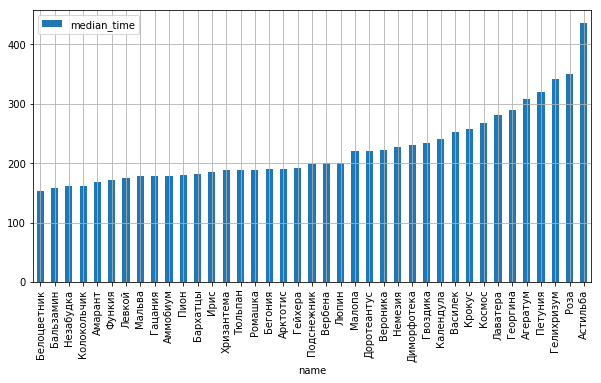

In [20]:
final_stat.dropna(subset=['median_time']).sort_values('median_time').plot(y='median_time', kind='bar', figsize=(10, 5), grid=True)

Что даёт этот факт? Клиентам «быстрых» АЗС оплата заправки через Яндекс.Навигатор вряд ли принесёт много ценности. 

Они и так заправляются, и платят быстро.

 А вот клиентам АЗС, чьи процессы отлажены не так хорошо, Яндекс.Навигатор поможет проводить меньше времени на станции. А сами АЗС могли бы значительно улучшить показатели. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D2C5320>]],
      dtype=object)

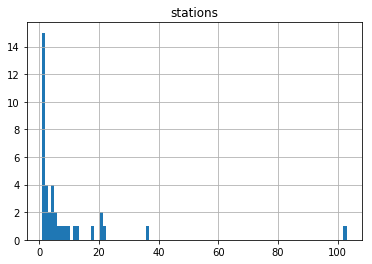

In [21]:
final_stat.hist('stations', bins=100)

Сеть — это звучит гордо! Особенно, когда в сети всего одна АЗС. У нас таких «гордых» целых 15. Есть группа таких, у которых меньше 10 станций. Есть и отдельные большие сети. 

Крупные рыбы интересуют нас в первую очередь, а мальков нужно собрать в одной группе.

In [22]:
big_nets_stat = final_stat.query('stations > 10')
print(big_nets_stat) 

             time_spent  good_time_spent  median_time  stations
name                                                           
Василек      268.849897            264.0       252.00     103.0
Гейхера      167.445947            204.0       192.00      12.0
Календула    207.357323            254.0       240.00      36.0
Колокольчик  119.131564            161.0       161.00      21.0
Люпин        235.440937            186.0       200.00      13.0
Мальва       136.562234            182.0       177.75      22.0
Немезия      186.535207            226.0       227.50      21.0
Роза         260.877217            315.0       350.00      18.0


In [23]:
station_stat_full['group_name'] = station_stat_full['name'].where(station_stat_full['name'].isin(big_nets_stat.index), 'Другие')
print(station_stat_full.head())

                 name  count  time_spent   group_name
id                                                   
00ca1b70     Вероника    131       166.0       Другие
0178ce70      Василек    164       234.5      Василек
01abf4e9      Гацания     30       181.5       Другие
030a9067  Колокольчик    228       135.5  Колокольчик
03740f2d      Василек    157       289.0      Василек


In [24]:
stat_grouped = (
    station_stat_full
    .query('count > 30')
    .pivot_table(index='group_name', values='time_spent', aggfunc=['median', 'count'])
)

stat_grouped.columns = ['time_spent', 'count']
stat_grouped.sort_values('time_spent', inplace=True)
print(stat_grouped)

             time_spent  count
group_name                    
Колокольчик      161.00     21
Мальва           177.75     22
Гейхера          192.00     12
Люпин            200.00     13
Другие           208.75    104
Немезия          227.50     21
Календула        240.00     36
Василек          252.00    103
Роза             350.00     18


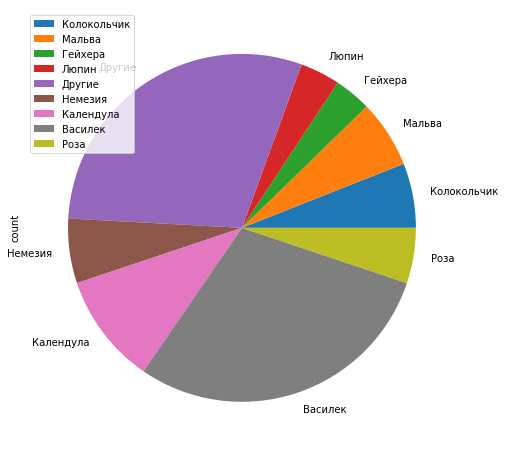

In [25]:
stat_grouped.plot(y='count', kind='pie', figsize=(8, 8), grid=True)

Вы получили финальный список наиболее интересных АЗС:
-   «Роза». Самая медленная среди крупных сетей.
-   «Василёк». Вторая по медлительности, но очень крупная по размеру сеть АЗС.
-   «Календула». Близка по времени к «Васильку» и вторая по величине.
-   «Немезия». Последняя из медленных и сравнительно крупных АЗС.

Проверка.

Переберём все сети и построим их гистограммы.

Затем получим срез из good_data методом query() и построим гистограмму по отфильтрованным данным. Однако в Pandas есть метод groupby, автоматически перебирающий уникальные значения. Передадим ему столбец, а он вернёт последовательность пар: значение столбца — срез данных с этим значением.

In [26]:
good_data['group_name'] = good_data['name'].where(good_data['name'].isin(big_nets_stat.index), 'Другие')

print(good_data.head())

            date_time        id  time_spent     name          local_time  \
0 2018-04-06 16:53:58  76144fb2        98.0  Василек 2018-04-06 19:53:58   
2 2018-04-03 17:28:24  76144fb2       220.0  Василек 2018-04-03 20:28:24   
6 2018-04-02 08:23:21  76144fb2       555.0  Василек 2018-04-02 11:23:21   
7 2018-04-07 00:34:08  76144fb2       286.0  Василек 2018-04-07 03:34:08   
9 2018-04-05 13:19:39  76144fb2       248.0  Василек 2018-04-05 16:19:39   

            date_hour  too_fast  too_slow group_name  
0 2018-04-06 20:00:00     False     False    Василек  
2 2018-04-03 20:00:00     False     False    Василек  
6 2018-04-02 11:00:00     False     False    Василек  
7 2018-04-07 04:00:00     False     False    Василек  
9 2018-04-05 16:00:00     False     False    Василек  


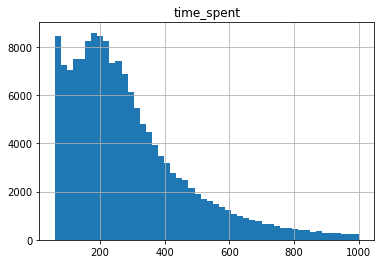

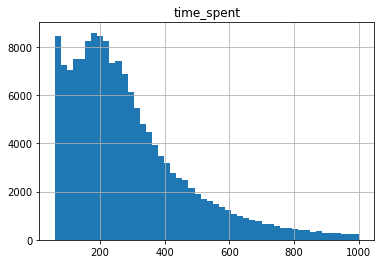

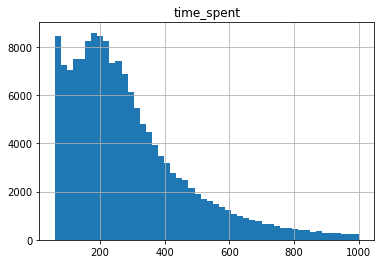

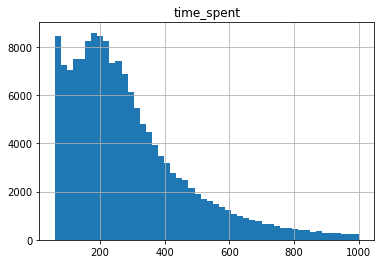

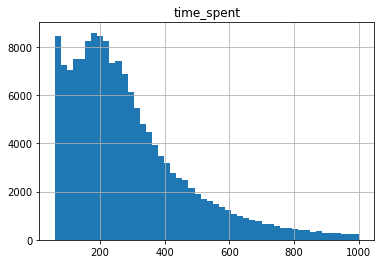

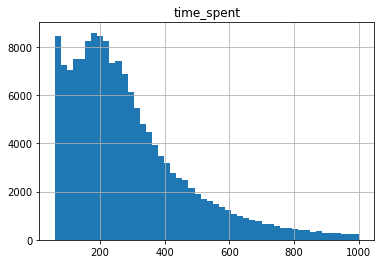

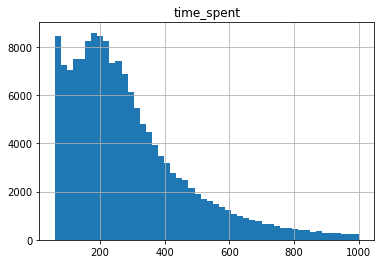

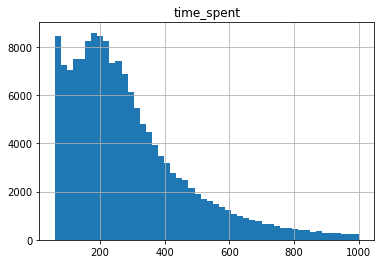

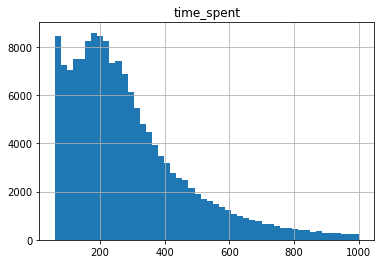

In [27]:
for name, group_data in good_data.groupby('group_name') :
    good_data.hist('time_spent', bins=50)

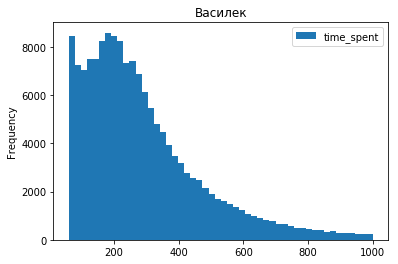

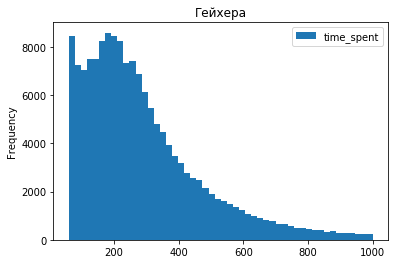

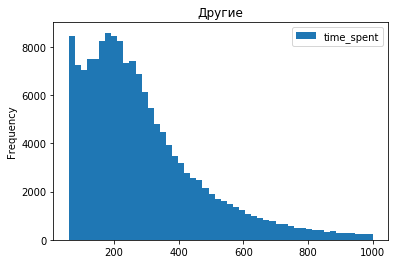

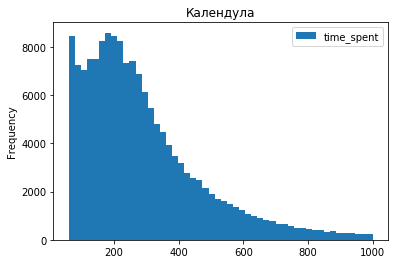

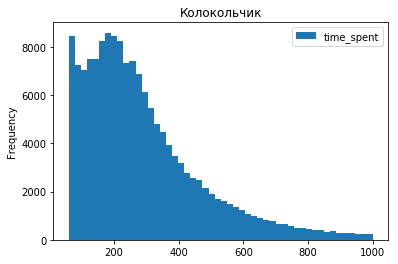

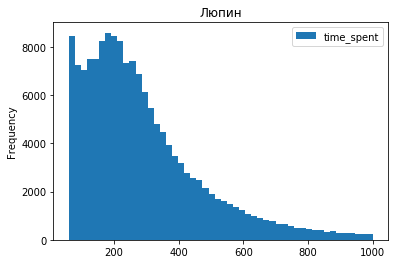

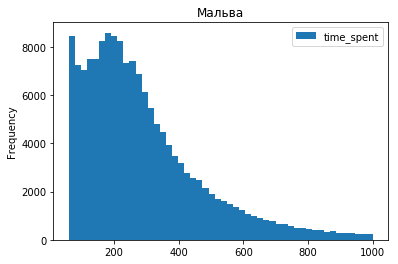

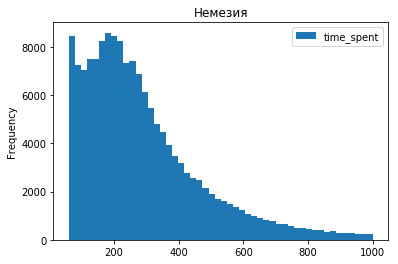

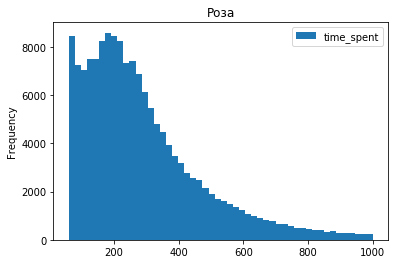

In [28]:
for name, group_data in good_data.groupby('group_name'):
    good_data.plot(y='time_spent', title = name, kind='hist', bins=50)

Распределения сетей большой восьмёрки похожи на пуассоновское. Если бы у них был огромный пик на коротких временах — это было бы плохо. А так посчитанные нами средние значения действительно хорошо передают реальное время заправки. Квалифицированный аналитик спит крепко!

У многих сетей АЗС явно обнаруживается аномальный пик на коротких поездках. Но в основном распределение ожидаемой формы, а значит медиана хорошо передаёт характерное время заправки.
Вы действительно выявили много долгих заправок в самых медленных сетях АЗС («Роза», «Календула», «Василёк», «Намезия»). Причём форма распределения достаточно плавная: не походит на явную аномалию на продолжительных временах заправки.
Данные действительно реалистичны